In [39]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import time, datetime
import sys
sys.path.append('..')
from utils import visualization
from importlib import reload
reload(visualization)

<module 'utils.visualization' from '/Users/apple/MSBD5003Project/parallel/../utils/visualization.py'>

In [58]:
FILE_PATH = "/Users/apple/spark/data/project/A-sets/a3.txt"

MIN_PTS = 4
EPSILON = 900
X_UNIT, Y_UNIT = 5000, 5000
SPAN_MARGIN = EPSILON/2 + 1
NOISE_LABEL = -2
DATA_NUM = 800

In [59]:
# read and organize the data as RDD
def parse_line(line):
    return [int(x) for x in line.strip().split()]

dataset = sc.textFile(FILE_PATH)\
    .map(parse_line)\
    .zipWithIndex().map(lambda x: (x[1], x[0]))\
    .filter(lambda x: x[0] < DATA_NUM) # only keep the first DATA_NUM points    
# plt.scatter(dataset.map(lambda x: x[1][0]).collect(), dataset.map(lambda x: x[1][1]).collect(), s=1)

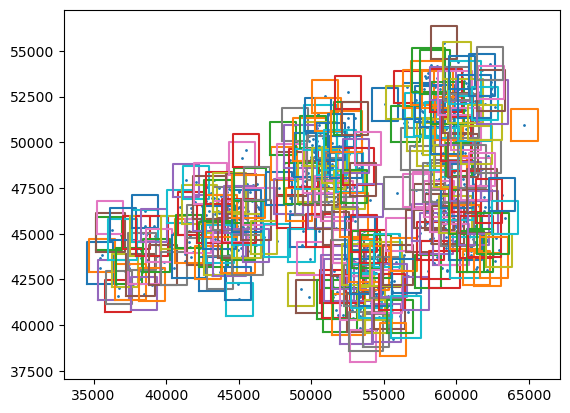

In [63]:
# test zrb code
import build_boxes
from importlib import reload
reload(build_boxes)
point_list_list_test = build_boxes.compute_area_list(dataset.values().collect(), EPSILON)
area_list_test = build_boxes.point_list_to_bounding_box(point_list_list_test, expand=EPSILON)

reload(visualization)
visualization.visualize_dataset_with_label(np.array(dataset.sortByKey().values().collect()), 
                                           label=None, noise_label=NOISE_LABEL,
                                           split_list=area_list_test)

35422 64691 38856 55436 
length: 29269 16580
after generating area_list, time used: 0.5663769245147705
area_list_rdd.count(): 292
after local dbscan, time used: 0.583611011505127


after merging intersecting sets, time used: 1.599294900894165
cluster_map: {113: 112, 114: 112, 122: 112, 123: 112, 124: 112, 131: 112, 132: 112, 133: 112, 134: 112, 135: 112, 136: 112, 144: 112, 145: 112, 146: 112, 147: 112, 148: 112, 149: 112, 150: 112, 151: 112, 157: 112, 158: 112, 159: 112, 160: 112, 161: 112, 162: 112, 163: 112, 167: 112, 168: 112, 169: 112, 170: 112, 171: 112, 172: 112, 173: 112, 174: 112, 175: 112, 176: 112, 177: 112, 178: 112, 179: 112, 182: 112, 183: 112, 184: 112, 185: 112, 189: 112, 190: 112, 5: 2, 6: 2, 9: 2, 10: 2, 81: 80, 83: 80, 84: 80, 85: 80, 86: 80, 91: 80, 92: 80, 93: 80, 94: 80, 97: 80, 98: 80, 99: 80, 100: 80, 101: 80, 102: 80, 104: 80, 105: 80, 106: 80, 107: 80, 108: 80, 109: 80, 110: 80, 115: 80, 116: 80, 117: 80, 118: 80, 119: 80, 120: 80, 121: 80, 126: 80, 127: 80, 128: 80, 129: 80, 130: 80, 138: 80, 139: 80, 140: 80, 141: 80, 142: 80, 152: 80, 153: 80, 154: 80, 165: 80, 166: 80, 4: 3, 7: 3, 8: 3, 11: 3, 12: 3, 13: 3, 15: 3, 16: 3, 17: 3, 18: 3

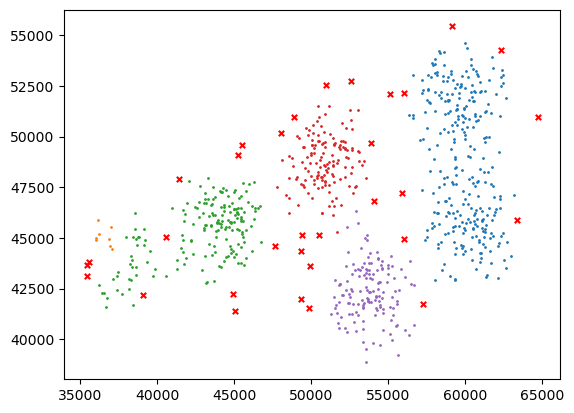

In [66]:
start_time = time.time()

x_min, x_max = dataset.map(lambda x: x[1][0]).min(), dataset.map(lambda x: x[1][0]).max()
y_min, y_max = dataset.map(lambda x: x[1][1]).min(), dataset.map(lambda x: x[1][1]).max()
print(x_min, x_max, y_min, y_max, '\nlength:', x_max-x_min, y_max-y_min)

x_grid = list(range(x_min, x_max + X_UNIT, X_UNIT))
y_grid = list(range(y_min, y_max + Y_UNIT, Y_UNIT))

area_list = []
area_cnt = 0
for x_idx, x_start in enumerate(x_grid[:-1]):
    for y_idx, y_start in enumerate(y_grid[:-1]):
        x_start_adjusted = x_start - SPAN_MARGIN
        y_start_adjusted = y_start - SPAN_MARGIN
        x_end_adjusted = x_grid[x_idx+1] + SPAN_MARGIN
        y_end_adjusted = y_grid[y_idx+1] + SPAN_MARGIN
        area_list.append([area_cnt, x_start_adjusted, x_end_adjusted, y_start_adjusted, y_end_adjusted])
        area_cnt += 1
assert len(area_list) == (len(x_grid)-1)*(len(y_grid)-1)

# TEST
area_list = area_list_test

print(f'after generating area_list, time used: {time.time()-start_time}')
print(f'area_list_rdd.count(): {len(area_list)}')


# for each point, find the area it belongs to (a point can belong to multiple areas)
def find_area(point):
    global area_list
    x, y = point
    area_idx_list = []
    for area in area_list:
        if area[1] <= x <= area[2] and area[3] <= y <= area[4]:
            area_idx_list.append(area[0])
    return area_idx_list

data_id_cluster_id_list = dataset.map(lambda x: (x[0], find_area(x[1]), x[1]))
# format: (data_id, [area_id1, area_id2, ...], (x, y))

# key: area_id
# value: [(point_id, (x, y)), (point_id, (x,y)), ...])
area_id_point_id_list = data_id_cluster_id_list.flatMap(
    lambda x: [(area_id, (x[0], x[2])) for area_id in x[1]])\
    .groupByKey().map(lambda x: (x[0], list(x[1])))

# convert the data in an area to a numpy array
# 3 columns: data_id, x, y
def convert_to_np_array(data_list):
    return np.array([[x[0], x[1][0], x[1][1]] for x in data_list])

area_id_np_array = area_id_point_id_list.mapValues(convert_to_np_array)
# key: area_id
# value: np.array, shape=(n, 3)

def dbscan_inline(data, eps, min_pts):
    '''
    data: np.array, shape=(N, 2)
    eps: float
    min_pts: int
    
    Returns:
    labels: np.array, shape=(N,)
    '''
    def find_neighbors(data, point, eps):
        neighbors_id = []
        for i, p in enumerate(data):
            if np.linalg.norm(p - point) < eps:
                neighbors_id.append(i)
        return neighbors_id
    
    N = data.shape[0]
    labels = np.zeros(N, dtype=int) - 1 # -1: unclassified; -2: noise; 1, 2, 3, ...: cluster id
    c = 0
    for i in range(N):
        if labels[i] != -1:
            continue
        neighbors_id = find_neighbors(data, data[i], eps)
        if len(neighbors_id) < min_pts:
            labels[i] = -2
            continue
        c += 1
        labels[i] = c
        neighbors_id_prime = neighbors_id.copy()
        assert i in neighbors_id_prime
        neighbors_id_prime.remove(i)
        for j in neighbors_id_prime:
            if labels[j] == -2:
                labels[j] = c
            if labels[j] != -1:
                continue
            labels[j] = c
            neighbors_j = find_neighbors(data, data[j], eps)
            if len(neighbors_j) >= min_pts:
                neighbors_id_prime += neighbors_j
    return labels

# for each area, find the points in it and perform local DBSCAN
def local_dbscan(data, eps, min_pts):
    '''
    data: np.array, shape (n, 3)
    '''
    data_id = data[:, 0]
    data = data[:, 1:]
    # print('will call dbscan with data shape:', data.shape)
    label_pred = dbscan_inline(data, eps, min_pts)
    return list(zip(data_id, label_pred))

data_id_label_pred_list = area_id_np_array.mapValues(lambda x: local_dbscan(x, EPSILON, MIN_PTS))
# key: area_id
# value: [(data_id, local_label), (data_id, local_label), ...]

print('after local dbscan, time used:', time.time()-start_time)


def transform_label(i: int, S: int, k, noise_label=-2) -> int:
    '''
    i: split id
    S: total number of splits
    k: the cluster id in split #i
    '''
    if k == noise_label:
        return noise_label
    else:
        return (k-1)*S + i

S = len(area_list)

data_id_corrected_label_pred_list = data_id_label_pred_list.map(lambda x: (x[0], [(y[0], transform_label(i=x[0], S=S, k=y[1])) for y in x[1]]))\
    .flatMap(lambda x: x[1])\
    .map(lambda x: (x[0], [x[1]]))\
    .reduceByKey(lambda x, y: x + y)
    # .cache()
    # .sortByKey().cache()
    # key = data_id, value = [label1, label2, ...]


set_list = data_id_corrected_label_pred_list.filter(lambda x: len(set(x[1])) > 1)
# key = data_id, value = [label1, label2, ...]


data_id_temp_label = data_id_corrected_label_pred_list.mapValues(lambda x: sorted(x)[-1])



def remove_noise_label_from_list(label_list, noise_label=-2):
    return [x for x in label_list if x != noise_label]


def merge_intersecting_sets(set_list):
        merged_sets = []
        while set_list:
            current_set = set_list.pop(0)  # 从list中取出一个集合
            merged = None
            # 查找第一个与current_set有交集的集合
            for i, merged_set in enumerate(merged_sets):
                if merged_set & current_set:
                    merged_set.update(current_set)
                    merged = i
                    break
            if merged is None:  # 没有发现交集
                merged_sets.append(current_set)
            else:  # 发现交集，再次合并可能的交集
                new_merged_set = merged_sets.pop(merged)
                set_list.append(new_merged_set)  # 将更新后的集合重新加入检查
        return merged_sets

def merge_sets_new(list1, list2):
    # 将两个列表合并为一个列表
    combined = list1 + list2
    merged_sets = merge_intersecting_sets(combined)
    return merged_sets

if set_list.count() != 0:
    merged_set_list = set_list.mapValues(remove_noise_label_from_list)\
        .mapValues(lambda x: [set(x)])\
        .values().treeReduce(lambda x, y: merge_sets_new(x, y))
else: # no intersecting sets
    merged_set_list = []


# merged_set_list = merge_intersecting_sets(real_set_list)
# # print('merged_set_list:', merged_set_list)
# # print('not_noise_data_cluster:', not_noise_data_cluster)

print('after merging intersecting sets, time used:', time.time()-start_time)

cluster_map = dict()
for merged_set in merged_set_list:
    if len(merged_set) < 2:
        continue
    merged_set = list(merged_set)
    for i in range(1, len(merged_set)):
        cluster_map[merged_set[i]] = merged_set[0]
        
print('cluster_map:', cluster_map)

# map and find the final cluster
def get_final_cluster(in_label):
    global cluster_map
    if cluster_map.get(in_label) is not None:
        return cluster_map[in_label]
    else:
        return in_label

data_id_final_cluster = data_id_temp_label.mapValues(get_final_cluster)

print('time used:', time.time()-start_time)


dataset_array = np.array(dataset.sortByKey().values().collect())#[data_id_final_cluster.keys().collect()]
visualization.visualize_dataset_with_label(dataset_array,
                                           label=np.array(data_id_final_cluster.sortByKey().values().collect()),
)#split_list=area_list)